# Data collection and preprocessing
 This notebook provides detailed instructions and code for collecting S&P100 stock data (sectors, fundamentals, historical prices). The data is first collected then normalized.

In [14]:
import wikipedia as wp
import pandas as pd
import yfinance as yf
import numpy as np
from ta.momentum import rsi
from ta.trend import macd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

We use Wikipedia to retrieve the S&P100 stocks list.

Minimal cleaning is required:
- Alphabet Inc. (Google) is listed twice, for its 'GOOG' and 'GOOGL' share classes. We keep 'GOOGL' (the older share class) and drop 'GOOG' to avoid redundancy.
- Wikipedia lists Berkshire Hathaway as 'BRK.B', but Yahoo Finance uses the ticker 'BRK-B'. We change the symbol to 'BRK-B'.
- Our model needs a full 10 years of data (about 2470 trading days), but newer companies like Palantir (IPO 2020) and Uber (IPO 2019) don't have this. Keeping them would require us to either truncate all 98 other stocks to match Palantir's short history (losing 5+ years of valuable data) or pad the missing years with zeros, which would completely skew the model. We choose to instead drop PLTR and UBER. 

In [15]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")

stocks = stocks.drop(["GOOG", "PLTR", "UBER"])
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})

stocks.head()


,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


In [16]:
stocks.to_csv("../data/raw/stocks.csv")

The fundamentals of the stocks, such as market capitalization or P/E Ratio, are collected via yfinance. These values will be used to find similarities between stock to create the graph.

In [17]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")

fundamentals.index = fundamentals.index.rename("Symbol")
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)

fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3995082424320,36.242626,32.535496,54.171505,7.46,8.31,4.991,0.1367,1.094,0.53,0.217828,54316450,9.738,0.26915
ABBV,385180336128,163.939830,17.975267,-2096.538300,1.33,12.13,-0.104,4.9015,0.507,3.78,0.087644,5337314,7.534,0.04004
ABT,214959357952,15.530151,23.957365,4.218681,7.96,5.16,29.303,0.2915,0.696,1.71,0.050744,5791825,5.030,0.31880
ACN,155096743936,20.584364,17.775410,4.985548,12.15,14.07,50.165,0.4872,1.278,1.45,-0.272754,4930442,2.194,0.11021
ADBE,142453768192,21.229568,16.560099,12.143519,16.03,20.55,28.024,0.0000,1.490,0.12,-0.293009,4365357,6.176,0.30012


In [18]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.188243,-0.085926,0.095466,0.322552,-0.182787,-0.212539,-0.101824,-0.479004,0.299774,-1.035468,0.280011,1.635441,0.852280,0.729941
ABBV,-0.081897,0.841493,-0.234084,-9.766269,-0.549436,-0.036819,-0.101933,5.088861,-1.105441,1.014741,-0.161309,-0.339436,0.413630,-1.235340
ABT,-0.283251,-0.236353,-0.098688,0.088227,-0.152881,-0.357440,-0.101306,-0.298114,-0.652995,-0.291085,-0.286400,-0.321110,-0.084728,1.155834
ACN,-0.354063,-0.199646,-0.238607,0.091824,0.097732,0.052421,-0.100861,-0.069430,0.740250,-0.455101,-1.383047,-0.355842,-0.649161,-0.633429
ADBE,-0.369018,-0.194961,-0.266114,0.125402,0.329803,0.350502,-0.101333,-0.638744,1.247756,-1.294110,-1.451712,-0.378626,0.143354,0.995599




ALR = annualized log return

Relative Strength Index (RSI): momentum indicator that measures the magnitude of recent price changes to evaluate overbought/oversold conditions

Moving Average Convergence Divergence (MACD): trend-following momentum indicator

In [20]:
values = [
	yf.Ticker(stock).history(period="10y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
	stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()

	stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
	stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
	stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
	stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
	stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21

	stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
	stock_values["ALR1W"] /= stock_values["ALR1W"].std()
	stock_values["ALR2W"] /= stock_values["ALR2W"].std()
	stock_values["ALR1M"] /= stock_values["ALR1M"].std()
	stock_values["ALR2M"] /= stock_values["ALR2M"].std()

	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])

	stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2016-01-04 00:00:00-05:00  23.776182  -1.213590        0.046584   
       2016-01-05 00:00:00-05:00  23.180359  -1.221945       -1.382949   
       2016-01-06 00:00:00-05:00  22.726723  -1.228307       -1.076970   
       2016-01-07 00:00:00-05:00  21.767557  -1.241758       -2.349732   
       2016-01-08 00:00:00-05:00  21.882660  -1.240144        0.287384   
       2016-01-11 00:00:00-05:00  22.236988  -1.235175        0.875275   
       2016-01-12 00:00:00-05:00  22.559723  -1.230649        0.785179   
       2016-01-13 00:00:00-05:00  21.979704  -1.238783       -1.419331   
       2016-01-14 00:00:00-05:00  22.460424  -1.232041        1.178951   
       2016-01-15 00:00:00-05:00  21.921030  -1.239606       -1.324610   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2016-01-04 00:00:00-05:00 -0.643187 -0.618213 -1.220123 -1.183828   
       2016-01-05 00:00:00-05:00 -1.004596 -0.580555 -1.418477 -1.504688   
       2016-01-06 00:00:00-05:00 -1.966747 -1.163614 -2.067022 -1.636428   
       2016-01-07 00:00:00-05:00 -2.734253 -1.933525 -2.521879 -1.972253   
       2016-01-08 00:00:00-05:00 -2.102979 -2.070639 -2.451471 -1.936344   
       2016-01-11 00:00:00-05:00 -1.713603 -1.679797 -1.977010 -1.760858   
       2016-01-12 00:00:00-05:00 -0.694870 -1.211290 -1.857565 -1.355832   
       2016-01-13 00:00:00-05:00 -0.855735 -2.011716 -1.857214 -1.533590   
       2016-01-14 00:00:00-05:00  0.802279 -1.377009 -1.513111 -1.315519   
       2016-01-15 00:00:00-05:00  0.044856 -1.466922 -1.592934 -1.268980   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2016-01-04 00:00:00-05:00  0.325944 -0.650458  
       2016-01-05 00:00:00-05:00  0.281394 -0.699483  
       2016-01-06 00:00:00-05:00  0.253036 -0.766110  
       2016-01-07 00:00:00-05:00  0.205810 -0.886094  
       2016-01-08 00:00:00-05:00  0.224515 -0.960819  
       2016-01-11 00:00:00-05:00  0.280679 -0.980149  
       2016-01-12 00:00:00-05:00  0.328390 -0.958379  
       2016-01-13 00:00:00-05:00  0.291029 -0.976670  
       2016-01-14 00:00:00-05:00  0.356386 -0.941522  
       2016-01-15 00:00:00-05:00  0.320666 -0.946284

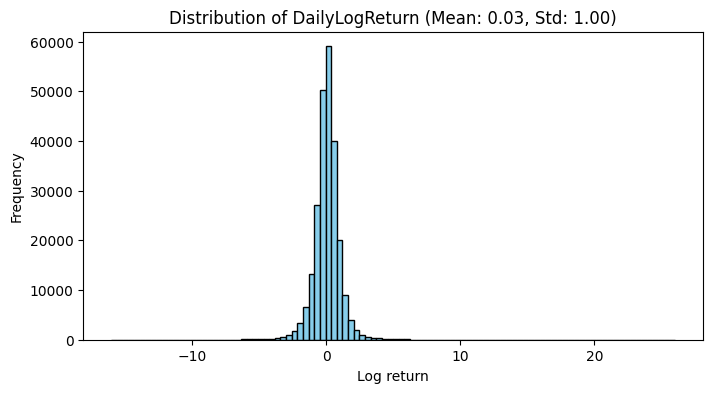

In [21]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

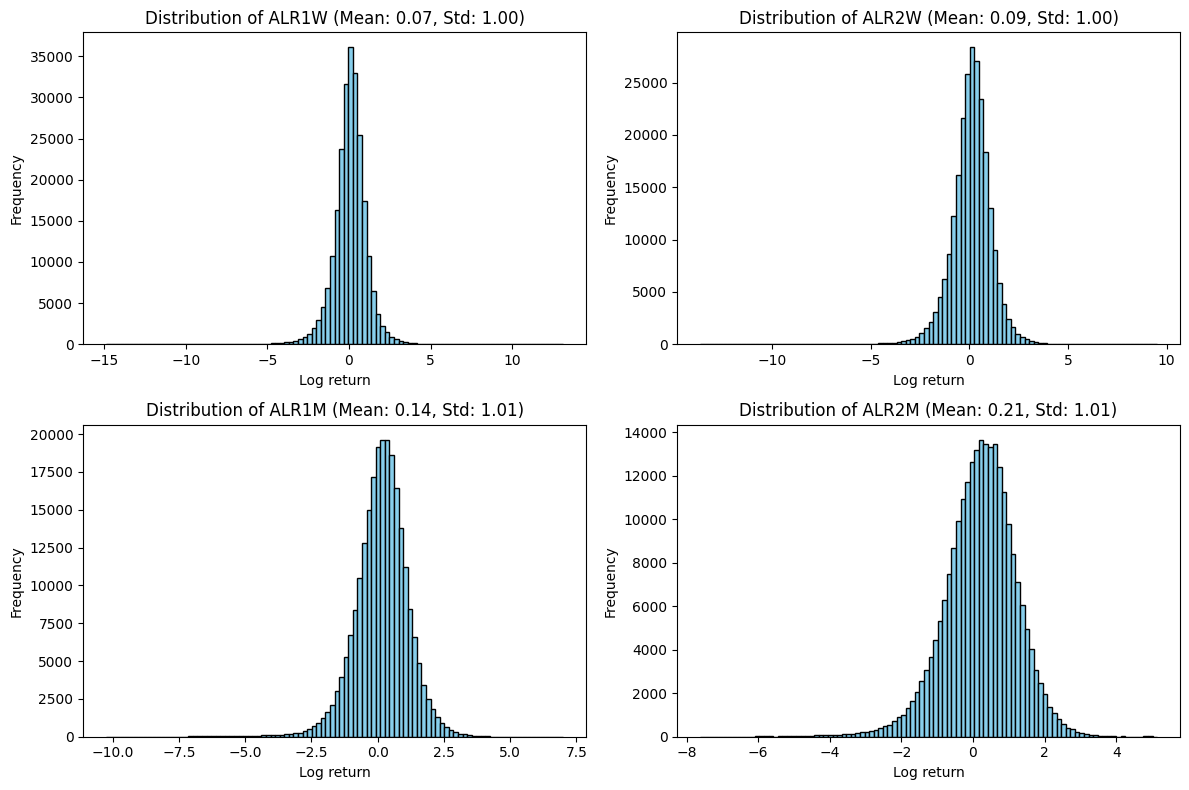

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

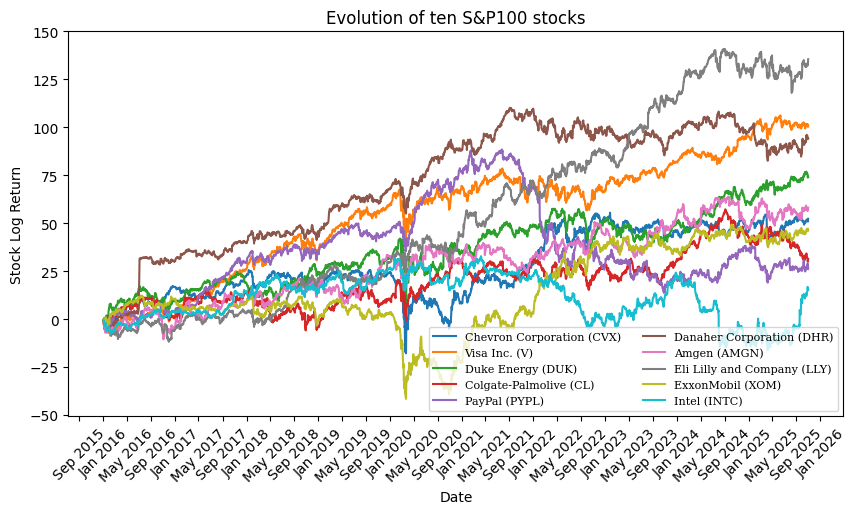

In [23]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

In [24]:
values.to_csv("../data/raw/values.csv")